In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 7.84576243e+02, -9.36140506e+01, -1.56635818e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 7.79803099e+02, -9.30955292e+01, -1.55628271e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 8.75985383e+02, -1.05724399e+02, -1.74737958e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 7.41200941e+02, -8.83453476e+01, -1.47991849e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 7.57661722e+02, -9.03470056e+01, -1.51268077e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 8.03441321e+02, -9.64539095e+01, -1.60332419e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:03<00:00, 15.10it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 10
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

  0%|          | 0/30192 [00:00<?, ?it/s]

100%|██████████| 30192/30192 [00:22<00:00, 1348.28it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 3639.9870
	Test: 	MSE Loss: 3602.8973
Epoch: 002
	Train:	MSE Loss: 2941.5333
	Test: 	MSE Loss: 3244.2955
Epoch: 003
	Train:	MSE Loss: 2679.8645
	Test: 	MSE Loss: 2742.0552
Epoch: 004
	Train:	MSE Loss: 2310.7500
	Test: 	MSE Loss: 2209.2456
Epoch: 005
	Train:	MSE Loss: 1880.8981
	Test: 	MSE Loss: 1511.6507
Epoch: 006
	Train:	MSE Loss: 1464.6724
	Test: 	MSE Loss: 1213.9060
Epoch: 007
	Train:	MSE Loss: 1259.3109
	Test: 	MSE Loss: 1120.3286
Epoch: 008
	Train:	MSE Loss: 1153.9005
	Test: 	MSE Loss: 1051.8840
Epoch: 009
	Train:	MSE Loss: 1074.1645
	Test: 	MSE Loss: 1008.1046
Epoch: 010
	Train:	MSE Loss: 999.4404
	Test: 	MSE Loss: 937.7346


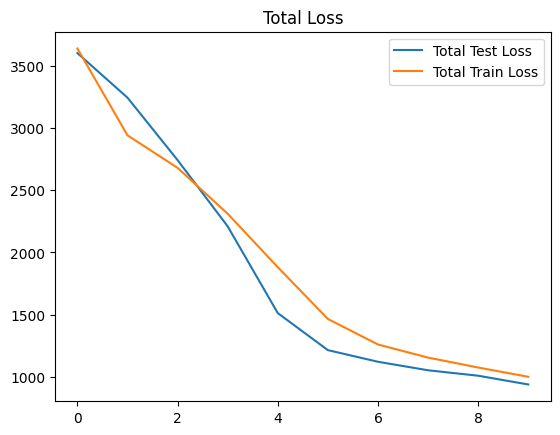

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

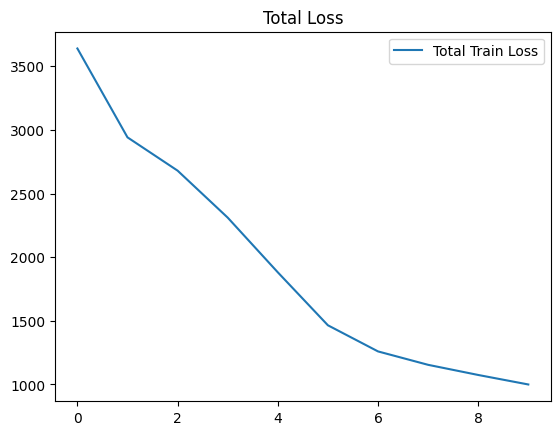

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

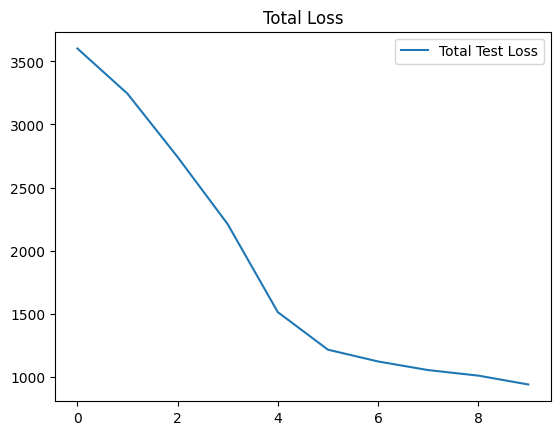

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 1010.7426918309479


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
# len(input_feature[0][heavy_indices])

(tensor([[-0.9781,  1.0337, -0.2990, 16.0953, 16.3582, 15.0522],
         [ 0.3357, -3.1476, -3.8509, 14.9485, 14.9408, 14.8311],
         [ 0.5529, -3.1561, -3.8607, 14.9424, 14.9334, 14.8263],
         [ 0.3928, -3.1498, -3.8535, 14.9469, 14.9388, 14.8299],
         [ 0.5306, -3.1552, -3.8597, 14.9430, 14.9341, 14.8268],
         [ 0.4224, -3.1510, -3.8548, 14.9461, 14.9378, 14.8292],
         [ 0.3817, -3.1494, -3.8530, 14.9472, 14.9392, 14.8301],
         [ 0.4509, -3.1521, -3.8561, 14.9453, 14.9369, 14.8285],
         [ 0.4746, -3.1530, -3.8572, 14.9446, 14.9360, 14.8280],
         [ 0.4773, -3.1531, -3.8573, 14.9445, 14.9359, 14.8280],
         [ 0.4698, -3.1528, -3.8570, 14.9447, 14.9362, 14.8281],
         [ 0.3706, -3.1489, -3.8525, 14.9475, 14.9396, 14.8303],
         [ 0.5341, -3.1553, -3.8598, 14.9429, 14.9340, 14.8267],
         [ 0.3875, -3.1496, -3.8533, 14.9471, 14.9390, 14.8300],
         [ 0.3498, -3.1481, -3.8516, 14.9481, 14.9403, 14.8308],
         [ 0.4770, -3.153

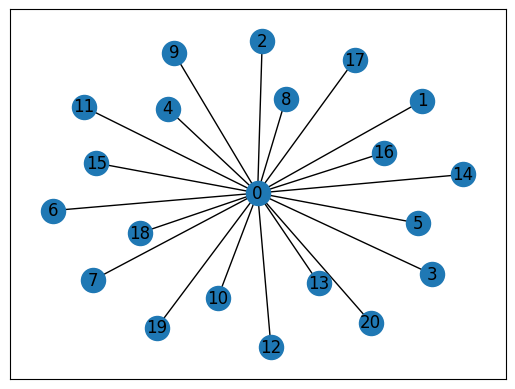

In [26]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
